# Replication DellaVigna & La Ferrara 2010

This notebook replicates results from

DellaVigna, S., & La Ferrara, E. (2010). [Detecting illegal arms trade.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.295.5439&rep=rep1&type=pdf) American Economic Journal: Economic Policy, 2(4), 26-57.
All data and the code can be found on [AEA webpage.](https://www.aeaweb.org/articles?id=10.1257/pol.2.4.26)

## Motivation

Authors try to come up with a method to detect illegal arm deals depending on investor knowledge. The paper exploits the the assumption that well-informed investors and company insiders unlike public are aware of the actions of the company and invest accordingly. These actions also include illegal arms trade to the countries under arms embargo directly or via an intermediary. Then main purpose of this paper is examining sudden increases and decreases of companies stocks on the dates an significant incident occurs in such countries due to such investment decisions.

After identifying the weapon-making companies using the standard industrial classification (SIC) code in the Data-stream Worldscope dataset, abnormal returns of 153 selected companies are examined in the three days surrounding the events (J. Paul Dunne and Eamon Surry 2006). The mechanism for company returns behavior is as follows; 

    “If a company is not trading or trading legally, an event increasing the hostilities should not affect its stock price or should affect it adversely, since it delays the removal of the embargo and hence the re-establishment of legal sales. Conversely, if a company is trading illegally, the event should increase its stock price, since it increases the demand for illegal weapons.”
    

### Causal Graphs

In [ ]:
from IPython.display import Image
display(Image('files/causal_under_embargo.jpg'))

In [ ]:
display(Image('files/causal_outside_embargo.jpg'))

## Selection of Countries, Events and Companies

### Countries under Embargo Selection Criteria

(i) Embargo should be imposed after 1980 to guarantee ovelapping with return data.<br>
(ii) Existense of at least one salient and unexpected conflict event during the embargo period.<br>
(iii) No large-scale UN or US intervention occurred in the conflict, to diminish the importance of sales.<br><br>
The final dataset includes Angola, Ethiopia and Eritrea, Liberia, Rwanda, Sierra Leone, Somalia, Sudan and former Yugoslavia.<br>Detalied list shared by the Authors can be found [here](Table A1)<br>
Replication Note: Most of the countries had UN or US interventions, however, none of them is considered as large-scale. Only Iraq and Afghanistan are eleminated due to criteria (iii) as mentioned in the paper.

### Event Selection

Criteria;<br>
(i) Important enough to attract the interest of media and investors<br>
(ii) To a first approximation, unanticipated<br>
(iii) Unambiguously increases or diminishes the intensity (and expected duration) of the conflict.

For (i) and (ii), an quantitative selection criteria is developed.<br><br>
**Event Importance** $i_t$ is the average of news on that day and the day after <br>
$i_t\ =\dfrac{n_t+n_{t+1}}{2}$<br><br>
**Event Suprise** $s_t$ is the ratio of the Event Importance to the average daily number of stories in the four days preeceding the event<br>
$s_t\ =\dfrac{(n_{t}+n_{t+1})/2}{(n_{t-1}+n_{t-2}+n_{t-3}+n_{t-4})/4}$<br><br>
Typically events with $i_t \geq 10$ and $s_t \geq 2$ are selected and for (iii) qualitative factors are considered.<br>
The detalied list of events including $i_t$ and $s_t$ shared by the Authors can be found [here](Table A2)

### Companies

Company selection is done with primarily using SIC codes in the Datastream-Worldscope dataset and using the list of top-100 weapon making companies in a paper published by Stockholm International Peace Research Institute(SIPRI) (J. Paul Dunne and Eamon Surry 2006).<br>
The detalied list of companies included in the paper shared by the Authors can be found [here](Table A4)

#### Company clustering

Regarding company characteristics various measures are used including <br>
(i) Corruption Perception Index (CPI) of Transparency International for the years 1995–2005;<br>
(ii) Small Arms Trade Transparency Barometer produced by the Small Arms Survey over the years 2004–2006;<br>
(iii) the index of Control of corruption (CC) proposed by Daniel Kaufmann, Aart Kraay,and Massimo Mastruzzi (2006);<br>
(iv) membership in the OECD in 1985;<br>
(v) a measure of press freedom provided by Freedom House;<br>
(vi) the Bribe PayersIndex (BPI), also produced by Transparency International;<br>
(vii) the self-dealing index of Simeon Djankov et al. (2008) as a measure of protection of small shareholders.<br>
The detailed list of measures of cost of embargo viaolation, shared by the Authors, can be found [here](Table A3)

#### Return

After dropping penny stocks(stocks with prices less than two units of locals currency), extreme outliers(top and bottom of 2/10,000 of returns) and stocks with stale price(returns zero for 10 consecutive days) following market model is estimated.

$r_{i,t} = \alpha_{i}+\beta_{i}r_{m(i),t}+\epsilon_{i,t}$<br>
$r_{i,t}$ = Return of Company $i$ on the day $t$<br>
$r_{m(i),t}$ = Return of the Value-Weighted Market Index for the Country in which Company $i$ is traded on the day $t$

Estimating $\hat{\alpha}_{i,t}$ and $\hat{\beta}_{i,t}$ from previous year, abnormal returns is calculated as follows;<br>
$e_{i,t} = r_{i,t}-\hat{\alpha}_{ti,t}-\hat{\beta}_{i,t}r_{m(i),t}$<br>
The main focus is on 3-day cumulative returns;<br>
$e_{i,t}^{(-1,1)} = e_{i,t-1}+e_{i,t}+e_{i,t+1}$<br>
since exact day may does not reflect the impact.

In [29]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels
from statsmodels.formula import api
import pysal
import patsy
from statsmodels.iolib import summary2
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

## Examination of Abnormal Returns

In [30]:
data = pd.read_stata('data/data1985.dta')
for x in range(1986,2004):
    data = data.append(pd.read_stata('data/data'+ str(x) +'.dta'),ignore_index=True)
for x in range(2004,2006):
    data = data.append(pd.read_stata('data/data'+ str(x)+ str(1) +'.dta'),ignore_index=True)
    data = data.append(pd.read_stata('data/data'+ str(x)+ str(2) +'.dta'),ignore_index=True)
data = data.drop(columns="index")        
data = data.sort_values(by="date")

Figure 1

Companies are clustered according to the countries of their headquarter's location and those countries differentiated as high-corrupted and low-corrupted in accordance with CPI.

In [31]:
evsnoemball1 = np.array(data["evsnoemb"])
evsnoemball= np.empty(len(evsnoemball1))
evsnenoemb = np.array(data["evsnenoemb"])

for i in range(1,len(evsnenoemb)):
    if (evsnenoemb[i]!=0):
        evsnoemball[i] = evsnenoemb[i]
    else:
        evsnoemball[i] = evsnoemball1[i]
        
evsnoemballd2cpi = evsnoemball*data["d2cpi"]
evsnoemballd2nocpi = evsnoemball*(1-data["d2cpi"])
data["evsnoemball"] = evsnoemball
data["evsnoemballd2cpi"] = evsnoemballd2cpi
data["evsnoemballd2nocpi"] = evsnoemballd2nocpi

for x in ["evsemb", "evsembd2cpi","evsembd2nocpi", "evsnoemball", "evsnoemballd2cpi", "evsnoemballd2nocpi"]:
    data["dp1"+ x] = (data[ x ]== 1)*1
    data["dm1"+ x] = (data[ x ]== -1)*1
    
for x in ["evsemb","evsnoemball"]:
    data["d0" + x] = (data[ x ]== 0)*1
    data["d0" + x + "d2cpi"] = ((data[ x ] == 0) & (data["d2cpi"] == 1 ))*1
    data["d0" + x + "d2nocpi"] = ((data[ x ] == 0) & (data["d2cpi"] == 0 ))*1

In [32]:
x = data[["dm1evsembd2nocpi","d0evsembd2nocpi", "dp1evsembd2nocpi", "dm1evsembd2cpi", "d0evsembd2cpi","dp1evsembd2cpi"]]
y = data["aret3ri"]
date = data["date"]
regF11 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#print(regF11.summary(xname=["Low corruption Decrease war", "Low corruption No event", "Low corruption Increase war",
#                           "High corruption Decrease war", "High corruption No event", "High corruption Increase war"]))

In [33]:
x = data[["dm1evsnoemballd2nocpi", "d0evsnoemballd2nocpi", "dp1evsnoemballd2nocpi", "dm1evsnoemballd2cpi", "d0evsnoemballd2cpi", "dp1evsnoemballd2cpi"]]
y = data["aret3ri"]
date = data["date"]
regF12 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#print(regF12.summary(xname=["Low corruption Decrease war", "Low corruption No event", "Low corruption Increase war",
#                           "High corruption Decrease war", "High corruption No event", "High corruption Increase war"]))

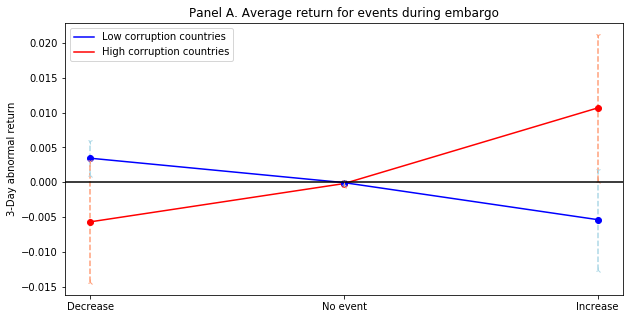

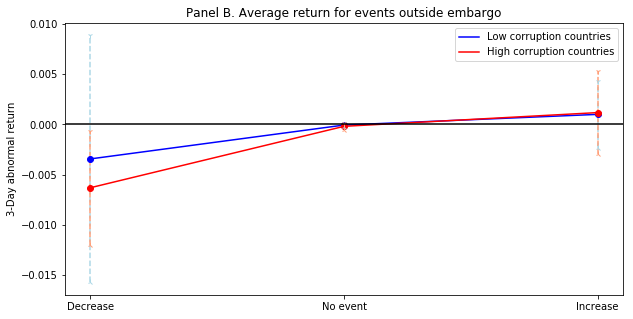

In [34]:
values = regF11.params
conf_inter = regF11.conf_int(alpha=0.05)

values_low_corrupt = pd.DataFrame(values[["dm1evsembd2nocpi","d0evsembd2nocpi","dp1evsembd2nocpi"]]).transpose()
conf_inter_lowc_l = pd.DataFrame(conf_inter[ 0 ][["dm1evsembd2nocpi","d0evsembd2nocpi","dp1evsembd2nocpi"]]).transpose()
conf_inter_lowc_h = pd.DataFrame(conf_inter[ 1 ][["dm1evsembd2nocpi","d0evsembd2nocpi","dp1evsembd2nocpi"]]).transpose()

values_high_corrupt = pd.DataFrame(values[["dm1evsembd2cpi","d0evsembd2cpi","dp1evsembd2cpi"]]).transpose()
conf_inter_highc_l = pd.DataFrame(conf_inter[ 0 ][["dm1evsembd2cpi","d0evsembd2cpi","dp1evsembd2cpi"]]).transpose()
conf_inter_highc_h = pd.DataFrame(conf_inter[ 1 ][["dm1evsembd2cpi","d0evsembd2cpi","dp1evsembd2cpi"]]).transpose()

col_low_cor = {"dm1evsembd2nocpi":"Decrease","d0evsembd2nocpi":"No event","dp1evsembd2nocpi":"Increase"}
col_high_cor = {"dm1evsembd2cpi":"Decrease","d0evsembd2cpi":"No event","dp1evsembd2cpi":"Increase"}

values_low_cor= values_low_corrupt.rename(columns = col_low_cor ).transpose()
conf_inter_low_cor_l = conf_inter_lowc_l.rename(columns = col_low_cor).transpose()
conf_inter_low_cor_h = conf_inter_lowc_h.rename(columns = col_low_cor).transpose()
values_high_cor = values_high_corrupt.rename(columns = col_high_cor).transpose()
conf_inter_high_cor_l = conf_inter_highc_l.rename(columns = col_high_cor).transpose()
conf_inter_high_cor_h = conf_inter_highc_h.rename(columns = col_high_cor).transpose()


plt.figure(figsize=(10,5))
plt.title('Panel A. Average return for events during embargo')
plt.ylabel('3-Day abnormal return')
plt.plot(values_low_cor,color = 'blue',)
plt.plot(values_high_cor,color = 'red')
plt.legend(labels=["Low corruption countries","High corruption countries"])        
plt.plot(values_high_cor,'ro',color = 'red')
plt.plot(values_low_cor,'ro',color = 'blue')
plt.plot(conf_inter_low_cor_l ,'2', color = 'lightblue')
plt.plot(conf_inter_low_cor_h ,'1', color = 'lightblue')
plt.plot(conf_inter_high_cor_l ,'2', color = 'lightsalmon')
plt.plot(conf_inter_high_cor_h ,'1', color = 'lightsalmon')
for a in ["low_cor","high_cor"]:
    for x in ["Decrease","No event","Increase"]:
        color_conf = "lightblue"
        if a == "high_cor": 
            color_conf = "lightsalmon"
        plt.vlines(x, ymax = globals()["conf_inter_"+ a + "_h"][1][x] , ymin = globals()["conf_inter_"+ a + "_l"][0][x],
                  color = color_conf, linestyle = 'dashed')
plt.axhline(y = 0 ,color = 'black')

values_noemb = regF12.params
conf_inter_noemb = regF12.conf_int(alpha=0.05)

values_noemb_low_corrupt = pd.DataFrame(values_noemb[["dm1evsnoemballd2nocpi","d0evsnoemballd2nocpi","dp1evsnoemballd2nocpi"]]).transpose()
conf_inter_noemb_lowc_l = pd.DataFrame(conf_inter_noemb[ 0 ][["dm1evsnoemballd2nocpi","d0evsnoemballd2nocpi","dp1evsnoemballd2nocpi"]]).transpose()
conf_inter_noemb_lowc_h = pd.DataFrame(conf_inter_noemb[ 1 ][["dm1evsnoemballd2nocpi","d0evsnoemballd2nocpi","dp1evsnoemballd2nocpi"]]).transpose()

values_noemb_high_corrupt = pd.DataFrame(values_noemb[["dm1evsnoemballd2cpi","d0evsnoemballd2cpi","dp1evsnoemballd2cpi"]]).transpose()
conf_inter_noemb_highc_l = pd.DataFrame(conf_inter_noemb[ 0 ][["dm1evsnoemballd2cpi","d0evsnoemballd2cpi","dp1evsnoemballd2cpi"]]).transpose()
conf_inter_noemb_highc_h = pd.DataFrame(conf_inter_noemb[ 1 ][["dm1evsnoemballd2cpi","d0evsnoemballd2cpi","dp1evsnoemballd2cpi"]]).transpose()
col_noemb_low_cor = {"dm1evsnoemballd2nocpi":"Decrease","d0evsnoemballd2nocpi":"No event","dp1evsnoemballd2nocpi":"Increase"}
col_noemb_high_cor = {"dm1evsnoemballd2cpi":"Decrease","d0evsnoemballd2cpi":"No event","dp1evsnoemballd2cpi":"Increase"}

values_noemb_low_cor= values_noemb_low_corrupt.rename(columns = col_noemb_low_cor ).transpose()
conf_inter_noemb_low_cor_l = conf_inter_noemb_lowc_l.rename(columns = col_noemb_low_cor).transpose()
conf_inter_noemb_low_cor_h = conf_inter_noemb_lowc_h.rename(columns = col_noemb_low_cor).transpose()
values_noemb_high_cor = values_noemb_high_corrupt.rename(columns = col_noemb_high_cor).transpose()
conf_inter_noemb_high_cor_l = conf_inter_noemb_highc_l.rename(columns = col_noemb_high_cor).transpose()
conf_inter_noemb_high_cor_h = conf_inter_noemb_highc_h.rename(columns = col_noemb_high_cor).transpose()

plt.figure(figsize=(10,5))
plt.title('Panel B. Average return for events outside embargo')
plt.ylabel('3-Day abnormal return')
plt.plot(values_noemb_low_cor,color = 'blue',)
plt.plot(values_noemb_high_cor,color = 'red')
plt.legend(labels=["Low corruption countries","High corruption countries"])
plt.plot(values_noemb_low_cor,'ro',color = 'blue')
plt.plot(values_noemb_high_cor,'ro',color = 'red')
plt.plot(conf_inter_noemb_low_cor_l ,'2', color = 'lightblue')
plt.plot(conf_inter_noemb_low_cor_h ,'1', color = 'lightblue')
plt.plot(conf_inter_noemb_high_cor_l ,'2', color = 'lightsalmon')
plt.plot(conf_inter_noemb_high_cor_h ,'1', color = 'lightsalmon')
for a in ["low_cor","high_cor"]:
    for x in ["Decrease","No event","Increase"]:
        color_conf = "lightblue"
        if a == "high_cor": 
            color_conf = "lightsalmon"
        plt.vlines(x, ymax = globals()["conf_inter_noemb_"+ a + "_h"][1][x] , ymin = globals()["conf_inter_noemb_"+ a + "_l"][0][x],
                  color = color_conf, linestyle = 'dashed')
plt.axhline(y = 0 ,color = 'black')



Average (equally-weighted) 3-Day abnormal return is regressed on ...<br>
Replication Note: Figures are approximately in line with the predictions, yet only a few are statistically significant at 95% level.

Figure 2

In [35]:
for i in ["1993-10-04","1996-04-29","1998-09-21","1998-12-14","1999-01-06","1999-08-10","1999-12-13","2003-06-05"]:
    data[ "dpos" + i + "nocpi" ] = ( data[ "date" ] == i ) * data[ "d2nocpi" ]
    data[ "dpos" + i + "cpi"] = ( data [ "date" ] == i ) * data[ "d2cpi" ]

In [36]:
for i in ["1994-07-04","1996-08-02","1998-03-10","1999-05-18","1999-09-28","2000-05-17","2000-12-12","2001-03-30","2002-02-22","2005-08-01"]:
    data[ "dpos" + i + "nocpi" ] = ( data[ "date" ] == i ) * data [ "d2nocpi" ]
    data[ "dpos" + i + "cpi"] = ( data [ "date" ] == i ) * data [ "d2cpi" ]

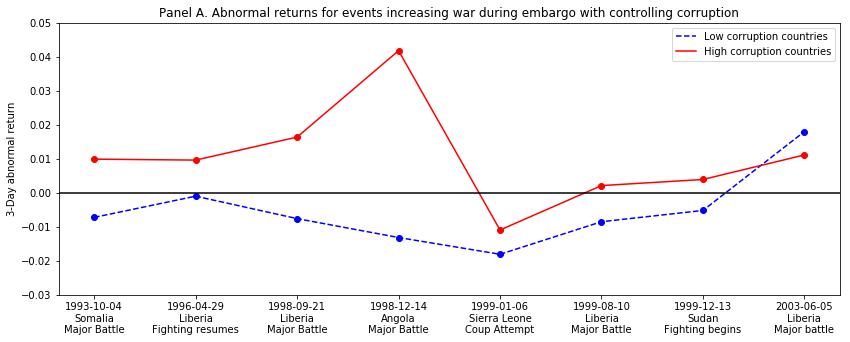

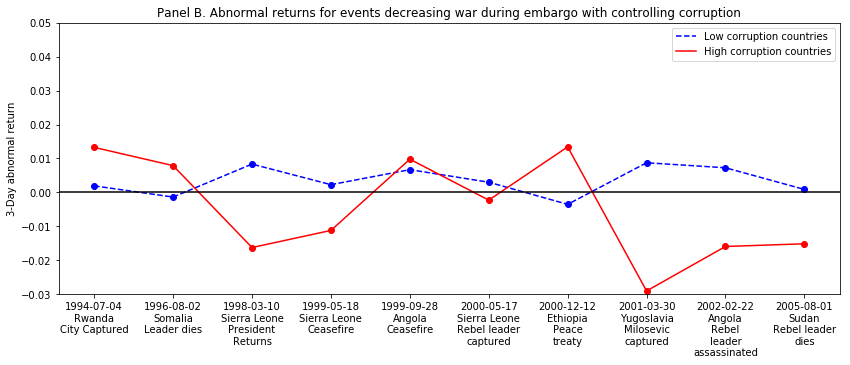

In [37]:
event_date_col = [col for col in data if col.startswith("dpos") | col.startswith("dneg")]
x = data[event_date_col]
y = data["aret3ri"]
regF121 = statsmodels.formula.api.OLS(y,x).fit(cov_type = "HC0",use_t = True)
#print(regF121.summary())

values = regF121.params
##For increasing war during embargo
inc_dates = ["1993-10-04", "1996-04-29", "1998-09-21", "1998-12-14", "1999-01-06", "1999-08-10", "1999-12-13", "2003-06-05"]
increasing_exp = {inc_dates[0]:"Somalia\nMajor Battle", inc_dates[1]:"Liberia\nFighting resumes",
                  inc_dates[2]:"Liberia\nMajor Battle", inc_dates[3]:"Angola\nMajor Battle",
                  inc_dates[4]:"Sierra Leone\nCoup Attempt", inc_dates[5]:"Liberia\nMajor Battle",
                  inc_dates[6]:"Sudan\nFighting begins", inc_dates[7]:"Liberia\nMajor battle"}
increasing_events_low_cor = pd.DataFrame(columns=["value"])
increasing_events_high_cor = pd.DataFrame(columns=["value"])

for x in inc_dates:
    increasing_events_low_cor = increasing_events_low_cor.append({'value': values["dpos"+ x + "nocpi"]}, ignore_index=True)
    increasing_events_high_cor = increasing_events_high_cor.append({'value': values["dpos"+ x + "cpi"]}, ignore_index = True)

for x in range(8):
    increasing_events_low_cor.rename(index = {x: str(inc_dates[x] +"\n"+ increasing_exp[inc_dates[x]])}, inplace=True)
    increasing_events_high_cor.rename(index = {x: str(inc_dates[x] +"\n"+ increasing_exp[inc_dates[x]])}, inplace=True)
##For decreasing war during embargo
decr_dates = ["1994-07-04", "1996-08-02", "1998-03-10", "1999-05-18", "1999-09-28",
              "2000-05-17", "2000-12-12", "2001-03-30", "2002-02-22", "2005-08-01"]
decreasing_exp = {decr_dates[0]:"Rwanda\nCity Captured", decr_dates[1]: "Somalia\nLeader dies",
                  decr_dates[2]:"Sierra Leone\nPresident\nReturns", decr_dates[3]:"Sierra Leone\nCeasefire",
                  decr_dates[4]:"Angola\nCeasefire", decr_dates[5]:"Sierra Leone\nRebel leader\ncaptured",
                  decr_dates[6]:"Ethiopia\nPeace\ntreaty", decr_dates[7]:"Yugoslavia\nMilosevic\ncaptured",
                  decr_dates[8]:"Angola\nRebel\nleader\nassassinated", decr_dates[9]:"Sudan\nRebel leader\ndies"}
decreasing_events_low_cor = pd.DataFrame(columns=["value"])
decreasing_events_high_cor = pd.DataFrame(columns=["value"])
for x in decr_dates:
    decreasing_events_low_cor = decreasing_events_low_cor.append({'value': values["dpos"+ x + "nocpi"]}, ignore_index=True)
    decreasing_events_high_cor = decreasing_events_high_cor.append({'value': values["dpos"+ x + "cpi"]}, ignore_index = True)

for x in range(10):
    decreasing_events_low_cor.rename(index = {x: str(decr_dates[x] +"\n"+ decreasing_exp[decr_dates[x]])}, inplace=True)
    decreasing_events_high_cor.rename(index = {x: str(decr_dates[x] +"\n"+ decreasing_exp[decr_dates[x]])}, inplace=True)

plt.figure(figsize=[14,5])
plt.title("Panel A. Abnormal returns for events increasing war during embargo with controlling corruption")
plt.ylabel('3-Day abnormal return')
plt.axis(ymin = -0.03, ymax = 0.05)
plt.plot(increasing_events_low_cor, color = 'blue', linestyle= 'dashed')
plt.plot(increasing_events_high_cor, color = 'red')
plt.plot(increasing_events_low_cor, 'ro', color = 'blue')
plt.plot(increasing_events_high_cor, 'ro', color = 'red')
plt.legend(labels=["Low corruption countries","High corruption countries"])
plt.axhline(y=0, color = 'black')

plt.figure(figsize=[14,5])
plt.title("Panel B. Abnormal returns for events decreasing war during embargo with controlling corruption")
plt.ylabel('3-Day abnormal return')
plt.axis(ymin = -0.03, ymax = 0.05)
plt.plot(decreasing_events_low_cor, color = 'blue', linestyle= 'dashed' )
plt.plot(decreasing_events_high_cor, color = 'red')
plt.plot(decreasing_events_low_cor, 'ro', color = 'blue')
plt.plot(decreasing_events_high_cor, 'ro', color = 'red')
plt.legend(labels=["Low corruption countries","High corruption countries"])
plt.axhline(y=0, color = 'black')


### Table 1 - BENCHMARK TABLE

In [38]:
#Adding a constant for convenience
data.loc[data["sample1"]==1,"const"] = 1

explanation_main = {"evsemb":"Event during embargo (1=increase,-1=decrease,0=no event)",
                    "evsembd2cpi":"Event during embargo(High-corruption country)",
                    "evsembd2nocpi":"Event during embargo(Low-corruption country)",
                    "d2cpi":"High-corruption country indicator", "const":"Constant"}
#Benchmark Spec. -- Interact with Corruption Index
x = data[["evsemb","evsembd2cpi","d2cpi","const"]]
x = x.rename(columns=explanation_main)
y = data["aret3ri"]
date = data["date"]
regT11 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

#Do only for events
x = data.loc[abs(data["evsemb"])==1, ["evsemb","evsembd2cpi"]]
x = x.rename(columns = explanation_main)
y = data.loc[abs(data["evsemb"])==1, "aret3ri"]
date = data.loc[abs(data["evsemb"])==1,"date"]
regT12 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

#Do for Corrupt and non-Corrupt
x = data[["evsembd2cpi","evsembd2nocpi","d2cpi","const"]]
x = x.rename(columns=explanation_main)
y = data["aret3ri"]
date = data["date"]
regT13 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table1 = summary2.summary_col([regT11,regT12,regT13],stars = True,
                     info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                     model_names = ['(1)','(2)','(3)'])
table1.add_title("Stock Market Reaction to War Events")

print(table1)

                         Stock Market Reaction to War Events
                                                            (1)       (2)       (3)   
--------------------------------------------------------------------------------------
Constant                                                 -0.0001             -0.0001  
                                                         (0.0001)            (0.0001) 
Event during embargo (1=increase,-1=decrease,0=no event) -0.0043** -0.0043**          
                                                         (0.0018)  (0.0018)           
Event during embargo(High-corruption country)            0.0121*** 0.0121**  0.0078** 
                                                         (0.0041)  (0.0042)  (0.0035) 
Event during embargo(Low-corruption country)                                 -0.0043**
                                                                             (0.0018) 
High-corruption country indicator                        -0.0001     

Table 2 - VARIOUS MEASURES OF COST OF ILLEGAL TRADES

In [39]:
##PANEL A
explanation = {"evsemb":"Event during embargo", "const":"Constant"}
for x in ["d2cpi","d2corrk","d2transp","now", "d2pressfr", "d2bpi06", "d2nodeal",
          "stcpi", "stcorrk", "sttransp", "stpressfr", "stbpi06", "stnodeal"]:
    new = {str("evsemb"+ x):"Event during embargo (Low cost)",
              x:"Low cost of embargo violation, indicator",}
    explanation.update(new)
#Interact with Corruption Index
x = data[["evsemb", "evsembd2cpi", "d2cpi","const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2A1 = statsmodels.formula.api.OLS(y,x).fit(cov_type = 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Corruption according to Kaufman
x = data[["evsemb", "evsembd2corrk", "d2corrk","const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2A2 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Transparency Index
x = data[["evsemb", "evsembd2transp", "d2transp", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["d2transp"]) <= 1,"date"]
reg2A3 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Western company
x = data[["evsemb", "evsembnow", "now", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["now"]) <= 1,"date"]
reg2A4 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Press Freedom
x = data[["evsemb", "evsembd2pressfr", "d2pressfr", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["d2pressfr"]) <= 1,"date"]
reg2A5 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Bribepayer
x = data[["evsemb", "evsembd2bpi06", "d2bpi06", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["d2bpi06"]) <= 1,"date"]
reg2A6 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Self-Dealing Index
x = data[["evsemb", "evsembd2nodeal", "d2nodeal", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["d2nodeal"]) <= 1,"date"]
reg2A7 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table2A = summary_col([reg2A1,reg2A2,reg2A3,reg2A4,reg2A5,reg2A6,reg2A7],stars = True,
                      info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                      model_names=["High\ncorruption\npercept.\nindex",
                                  "Control of\ncorruption index", "Low\ntransparency\nof arms\ntrade",
                                  "Non\nOECD\nmember","Low\npress\nfreedom", "High\nbribe-payer\nindex",
                                  "High\nself-dealing\nindex"])
                     
##PANEL B. Continuous variables
#Interact with Corruption Variable
x = data[["evsemb", "evsembstcpi", "stcpi", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2B1 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Corruption according to Kaufman
x = data[["evsemb", "evsembstcorrk", "stcorrk", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2B2 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Transparency Index
x = data[["evsemb", "evsembsttransp", "sttransp", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["sttransp"]) <= 3,"date"]
reg2B3 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Press Freedom
x = data[["evsemb", "evsembstpressfr", "stpressfr", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2B5 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Bribepayer
x = data[["evsemb", "evsembstbpi06", "stbpi06", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data.loc[abs(data["stbpi06"]) <= 2,"date"]
reg2B6 = statsmodels.formula.api.OLS(y,x,missing = "drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Shleifer Index
x = data[["evsemb", "evsembstnodeal", "stnodeal", "const"]]
x = x.rename(columns = explanation)
y = data["aret3ri"]
date = data["date"]
reg2B7 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table2B = summary_col([reg2B1,reg2B2,reg2B3,reg2B5,reg2B6,reg2B7],stars = True,
                      info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                      model_names=["High\ncorruption\npercept.\nindex",
                                  "Control of\ncorruption index", "Low\ntransparency\nof arms\ntrade",
                                  "Low\npress\nfreedom", "High\nbribe-payer\nindex", "High\nself-dealing\nindex"])
table2A.add_title("Panel A. Indicators for cost of embargo violation")
table2B.add_title("Panel B. Standardized continuous variables for cost of embargo violation")

Stock Market Reaction: Measures for Cost of Embargo Violation

In [40]:
print(table2A)

                                      Panel A. Indicators for cost of embargo violation
                                            High       Control of        Low         Non      Low        High        High    
                                         corruption corruption index transparency    OECD    press   bribe-payer self-dealing
                                          percept.                     of arms      member  freedom     index       index    
                                           index                        trade                                                
-----------------------------------------------------------------------------------------------------------------------------
Event during embargo                     -0.0043**  -0.0044**        -0.0045**    -0.0034** -0.0025  -0.0030*    -0.0025     
                                         (0.0018)   (0.0018)         (0.0020)     (0.0017)  (0.0017) (0.0016)    (0.0015)    
Event during embargo (Low cost

In [41]:
print(table2B)

                     Panel B. Standardized continuous variables for cost of embargo violation
                                            High       Control of        Low        Low        High        High    
                                         corruption corruption index transparency  press   bribe-payer self-dealing
                                          percept.                     of arms    freedom     index       index    
                                           index                        trade                                      
-------------------------------------------------------------------------------------------------------------------
Event during embargo                     0.0015     0.0020           0.0026       0.0013   0.0009      -0.0006     
                                         (0.0018)   (0.0019)         (0.0025)     (0.0015) (0.0018)    (0.0017)    
Event during embargo (Low cost)          0.0071***  0.0078***        0.0050**     0.0050** 0.0

Table 3 - EVENT SELECTION TABLE

In [42]:
#Do with standard event definition
explanation_evnt = {'evsemb':'Event during embargo (event ind.)',
                    'evsembd2cpi':'Event during embargo(High-corruption)',
                    'evlemb':'Event during embargo(broad defn) (event ind.)',
                    'evlembd2cpi':'Event during embargo(broad defn) (High-corruption)',
                    'evs2emb':'Event during embargo(automatic defn) (event ind.)',
                    'evs2embd2cpi':'Event during embargo(automatic defn) (High-corruption)',
                    'evs3emb':'Event during embargo(automatic defn) (event ind.)',
                    'evs3embd2cpi':'Event during embargo(automatic defn) (High-corruption)',
                    'd2cpi':'Indicator for high-corruption','const':'Constant'}
x = data[["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_evnt)
y = data["aret3ri"]
date = data["date"]
reg31 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Do with weak event definition
x = data[["evlemb", "evlembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_evnt)
y = data["aret3ri"]
date = data["date"]
reg32 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Do with both event definitions
x = data[["evsemb", "evsembd2cpi","evlemb", "evlembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_evnt)
y = data["aret3ri"]
date = data["date"]
reg33 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
# Do with "automated" event definition -- s2
x = data[["evs2emb", "evs2embd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_evnt)
y = data["aret3ri"]
date = data["date"]
reg34 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Do with "automated" event definition -- s3
x = data[["evs3emb", "evs3embd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_evnt)
y = data["aret3ri"]
date = data["date"]
reg35 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table3 = summary_col([reg31,reg32,reg33,reg34,reg35],stars=True,
                     info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                     model_names=['(1)','(2)','(3)','(4)','(5)'])
table3.add_title("Stock Market Reaction: Event Selection")
print(table3)

                                 Stock Market Reaction: Event Selection
                                                          (1)       (2)      (3)       (4)       (5)    
--------------------------------------------------------------------------------------------------------
Constant                                               -0.0001   -0.0001   -0.0001  -0.0001   -0.0001   
                                                       (0.0001)  (0.0001)  (0.0001) (0.0001)  (0.0001)  
Event during embargo (event ind.)                      -0.0043**           -0.0038                      
                                                       (0.0018)            (0.0026)                     
Event during embargo(High-corruption)                  0.0121***           0.0102**                     
                                                       (0.0041)            (0.0048)                     
Event during embargo(automatic defn) (High-corruption)                              0.00

Table 4 - BY TYPE OF ARMS BEING TRADED

In [43]:
#Table with small companies
x = data.loc[data["drevq1"] == 1, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["drevq1"] == 1,"aret3ri"]
date = data.loc[data["drevq1"] == 1,"date"]
reg411 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#large companies
x = data.loc[data["drevq1"] == 0, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["drevq1"] == 0,"aret3ri"]
date = data.loc[data["drevq1"] == 0,"date"]
reg412 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#By type of arms
##Ammunition
x = data.loc[data["sampleamms"] == 1, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["sampleamms"] == 1,"aret3ri"]
date = data.loc[data["sampleamms"] == 1,"date"]
reg421 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
##Missiles
x = data.loc[data["samplemisss"] == 1, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["samplemisss"] == 1,"aret3ri"]
date = data.loc[data["samplemisss"] == 1,"date"]
reg422 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Tanks
x = data.loc[data["sampletanks"] == 1, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["sampletanks"] == 1,"aret3ri"]
date = data.loc[data["sampletanks"] == 1,"date"]
reg423 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Explosives
x = data.loc[data["sampleexps"] == 1, ["evsemb", "evsembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_main)
y = data.loc[data["sampleexps"] == 1,"aret3ri"]
date = data.loc[data["sampleexps"] == 1,"date"]
reg424 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table4 = summary_col([reg411,reg412,reg421,reg422,reg423,reg424],stars=True,
                     info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                     model_names=['Small firms','Large Firms','Small arms &\nAmmunition','Missiles','Tanks','Explosives'])
table4.add_title("Stock Market Reaction by Firm Characteristics")
print(table4)

                                      Stock Market Reaction by Firm Characteristics
                                                         Small firms Large Firms Small arms & Missiles  Tanks   Explosives
                                                                                  Ammunition                              
--------------------------------------------------------------------------------------------------------------------------
Event during embargo (1=increase,-1=decrease,0=no event) -0.0101***  -0.0026     -0.0046      -0.0060* -0.0047  -0.0077   
                                                         (0.0029)    (0.0018)    (0.0036)     (0.0035) (0.0042) (0.0047)  
Event during embargo(High-corruption country)            0.0215***   0.0076*     0.0101*      0.0361** 0.0032   0.0139*   
                                                         (0.0053)    (0.0042)    (0.0055)     (0.0184) (0.0048) (0.0082)  
High-corruption country indicator                      

TABLE 5 -- EVENTS IN NON-EMBARGO PERIODS

In [44]:
#Table NoEmb -- Results outside embargo
explanation_noemb = {"evsemb":"Event during embargo (event ind.)",
                     "evsembd2cpi":"Event during embargo (High-corruption)",
                     "evsembd2transp":"Event during embargo (High-corruption)",
                     "evsnoemb":"Event outside embargo (event ind.)",
                     "evsnoembd2cpi":"Event outside embargo (High-corruption)",
                     "evsnoembd2transp":"Event outside embargo (High-corruption)",
                     "evsnenoemb":"Event in countries without embargo (event ind.)",
                     "evsnenoembd2cpi":"Event in countries without embargo (High-corruption)",
                     "evsnenoembd2transp":"Event in countries without embargo (High-corruption)",
                     "d2cpi":"Indicator for low-cost of embargo viaolation",
                     "d2transp":"Indicator for low-cost of embargo viaolation"}

x = data[["evsemb", "evsnoemb", "evsnenoemb","evsembd2cpi", "evsembd2transp", "evsnoembd2cpi","evsnoembd2transp",
          "evsnenoembd2cpi", "evsnenoembd2transp","d2cpi", "d2transp", "const"]]
x = x.rename(columns=explanation_noemb)
y = data["aret3ri"]
date = data.loc[data["d2transp"]>= min(data["d2transp"]),"date"]
reg51 = statsmodels.formula.api.OLS(y,x, missing="drop").fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Basic spec
x = data[["evsemb", "evsnoemb", "evsnenoemb", "const"]]
x = x.rename(columns=explanation_noemb)
y = data["aret3ri"]
date = data["date"]
reg52 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Corruption Index
x = data[["evsemb", "evsembd2cpi", "evsnoemb", "evsnoembd2cpi", "evsnenoemb", "evsnenoembd2cpi", "d2cpi", "const"]]
x = x.rename(columns=explanation_noemb)
y = data["aret3ri"]
date = data["date"]
reg53 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#Interact with Transparency Index
x = data[["evsemb", "evsembd2transp", "evsnoemb", "evsnoembd2transp", "evsnenoemb", "evsnenoembd2transp", "d2transp", "const"]]
x = x.rename(columns=explanation_noemb)
y = data["aret3ri"]
date = data.loc[data["d2transp"]>= min(data["d2transp"]),"date"]
reg54 = statsmodels.formula.api.OLS(y,x, missing = 'drop').fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

table5 = summary_col([reg52,reg53,reg54],stars=True,
                     info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                     model_names=['(1)','(2)','(3)'])
table5.add_title("Stock Market Reaction to Events Outside the Embargo")
print(table5)

               Stock Market Reaction to Events Outside the Embargo
                                                       (1)       (2)       (3)   
---------------------------------------------------------------------------------
Event during embargo (High-corruption)                        0.0121*** 0.0117***
                                                              (0.0041)  (0.0043) 
Event during embargo (event ind.)                    -0.0009  -0.0043** -0.0045**
                                                     (0.0015) (0.0018)  (0.0020) 
Event in countries without embargo (High-corruption)          0.0013    0.0012   
                                                              (0.0029)  (0.0031) 
Event in countries without embargo (event ind.)      0.0028   0.0025    0.0024   
                                                     (0.0019) (0.0022)  (0.0023) 
Event outside embargo (High-corruption)                       -0.0006   0.0007   
                               

PLACEBO TREATMENTS IN TEXT -- MARKET RETURNS

In [45]:
x = data[["evsemb", "evsembd2cpi", "d2cpi", "const"]]
y = data["ret3li"]
date = data["date"]
reg_pla = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#print(reg_pla.summary())

In [46]:
#WEB APPENDIX TABLE 6 -- TIMING OF EFFECTS

In [47]:
liste = []
for _ in ["m2","m1","","p1","p2"]:
    x = data[["evsemb", "evsembd2cpi", "d2cpi" ,"const"]]
    x = x.rename(columns=explanation_main)
    y = data["aretri"+ _ ]
    date = data.loc[y.notna(), "date"]
    reg6 = statsmodels.formula.api.OLS(y,x, missing = 'drop').fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
    liste.append(reg6)
table6 = summary_col(liste, stars = True, info_dict={'Observations':lambda x: "{:,}".format(int(x.nobs))},
                     model_names=['(-2,-2)','(-1,-1)','(0,0)','(1,1)','(2,2)'])
table6.add_title("Table 6, Timing of Stock Market Reaction")
print(table6)

                                Table 6, Timing of Stock Market Reaction
                                                         (-2,-2)   (-1,-1)     (0,0)    (1,1)    (2,2)  
--------------------------------------------------------------------------------------------------------
Event during embargo (1=increase,-1=decrease,0=no event) 0.0003   -0.0020*** -0.0008   -0.0015  0.0015**
                                                         (0.0015) (0.0007)   (0.0012)  (0.0009) (0.0007)
Event during embargo(High-corruption country)            0.0024   0.0023     0.0057*** 0.0041** -0.0003 
                                                         (0.0017) (0.0020)   (0.0020)  (0.0019) (0.0024)
High-corruption country indicator                        -0.0001  -0.0001    -0.0000   -0.0000  -0.0000 
                                                         (0.0001) (0.0001)   (0.0001)  (0.0001) (0.0001)
Constant                                                 -0.0000  -0.0000    -0.0000   

FIGURE 3 -- TIMING OF EFFECT

In [50]:
x = data[["d2cpi", "const"]]
y = data["aretri"]
date = data["date"]
reg31 = statsmodels.formula.api.OLS(y,x).fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)

x = data[["evsembd2cpi", "evsembd2nocpi", "d2cpi" ,"const"]]
for i in ["m","p"]:
    for _ in range(1,16):
        mark = i + str(_)
        data["evsemb"+ mark + "d2cpi"] = data["evsemb"+ mark] * data["d2cpi"]
        data["evsemb"+ mark + "d2nocpi"] = data["evsemb"+ mark] * (1-data["d2cpi"])
        x = x.join(data[["evsemb"+ mark + "d2cpi","evsemb" + mark + "d2nocpi"]])
        data = data.drop(columns = "evsemb"+ mark + "d2cpi")
        data = data.drop(columns = "evsemb"+ mark + "d2nocpi")
y = data["aretri"]
date = data.loc[x.dropna().index , "date"]
reg32 = statsmodels.formula.api.OLS(y,x , missing = 'drop').fit(cov_type= 'cluster',cov_kwds={'groups':date},use_t = True)
#For High corruption countries
corrupt = pd.DataFrame(columns=["value","c_low","c_high"], index = range(1,32))
conf_inter = reg32.conf_int(alpha=0.05)
i = 1
for _ in reversed(range(1,16)):
    corrupt["value"][i] = reg32.params["evsembp"+ str(_) + "d2cpi"]
    corrupt["c_low"][i] = conf_inter[ 0 ]["evsembp"+ str(_) + "d2cpi"]
    corrupt["c_high"][i] = conf_inter [ 1 ]["evsembp"+ str(_) + "d2cpi"]
    i = i + 1

corrupt["value"][i] = reg32.params["evsembd2cpi"]
corrupt["c_low"][i] = conf_inter [ 0 ]["evsembd2cpi"]
corrupt["c_high"][i] = conf_inter [ 1 ]["evsembd2cpi"]
i = i + 1

for _ in range(1,16):
    corrupt["value"][i] = reg32.params["evsembm"+ str(_) + "d2cpi"]
    corrupt["c_low"][i] = conf_inter[ 0 ]["evsembm"+ str(_) + "d2cpi"]
    corrupt["c_high"][i] = conf_inter[ 1 ]["evsembm"+ str(_) + "d2cpi"]
    i = i + 1
#For low corruption countries
no_corrupt = pd.DataFrame(columns=["value","c_low","c_high"], index = range(1,32))
conf_inter = reg32.conf_int(alpha=0.05)
i = 1
for _ in reversed(range(1,16)):
    no_corrupt["value"][i] = reg32.params["evsembp"+ str(_) + "d2nocpi"]
    no_corrupt["c_low"][i] = conf_inter[ 0 ]["evsembp"+ str(_) + "d2nocpi"]
    no_corrupt["c_high"][i] = conf_inter [ 1 ]["evsembp"+ str(_) + "d2nocpi"]
    i = i + 1

no_corrupt["value"][i] = reg32.params["evsembd2cpi"]
no_corrupt["c_low"][i] = conf_inter [ 0 ]["evsembd2cpi"]
no_corrupt["c_high"][i] = conf_inter [ 1 ]["evsembd2cpi"]
i = i + 1

for _ in range(1,16):
    no_corrupt["value"][i] = reg32.params["evsembm"+ str(_) + "d2nocpi"]
    no_corrupt["c_low"][i] = conf_inter[ 0 ]["evsembm"+ str(_) + "d2nocpi"]
    no_corrupt["c_high"][i] = conf_inter[ 1 ]["evsembm"+ str(_) + "d2nocpi"]
    i = i + 1

i = 1
for _ in range(-15,16,1):
    corrupt = corrupt.rename(index = {i:_})
    no_corrupt = no_corrupt.rename(index = {i:_})
    i = i + 1

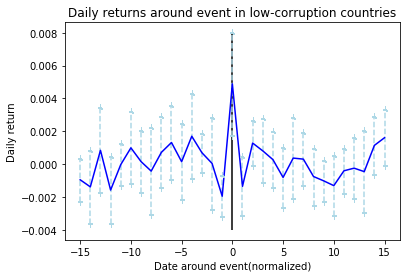

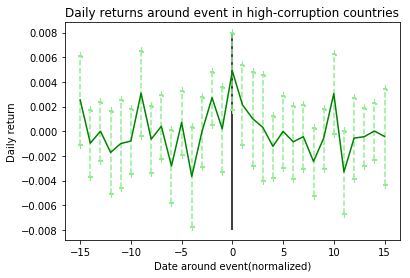

In [28]:
plt.figure()
plt.plot(no_corrupt["value"][list(range(-15,16,1))],color = "blue")
plt.vlines(x=0, ymin = -0.004, ymax = 0.008)
plt.title("Daily returns around event in low-corruption countries")
plt.ylabel("Daily return")
plt.xlabel("Date around event(normalized)")
for _ in range(-15,16,1):
    plt.vlines( x = _ , ymax = no_corrupt["c_high"][_], ymin = no_corrupt["c_low"][_], color = 'lightblue' , linestyles= 'dashed')
    plt.plot(no_corrupt["c_low"][list(range(-15,16,1))], '1', color = 'lightblue')
    plt.plot(no_corrupt["c_high"][list(range(-15,16,1))], '2', color = 'lightblue')

plt.figure()
plt.plot(corrupt["value"][list(range(-15,16,1))],color = "green")
plt.title("Daily returns around event in high-corruption countries")
plt.ylabel("Daily return")
plt.xlabel("Date around event(normalized)")
plt.vlines(x=0, ymin = -0.008, ymax = 0.008)
for _ in range(-15,16,1):
    plt.vlines( x = _ , ymax = corrupt["c_high"][_], ymin = corrupt["c_low"][_], color = 'lightgreen' , linestyles= 'dashed')
    plt.plot(corrupt["c_low"][list(range(-15,16,1))], '1', color = 'lightgreen')
    plt.plot(corrupt["c_high"][list(range(-15,16,1))], '2', color = 'lightgreen')


FIGURE 4A AND 4B -- TEMPORAL PLACEBO

Text(0.5,0,'Estimated coefficient')

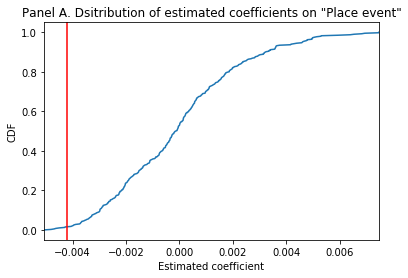

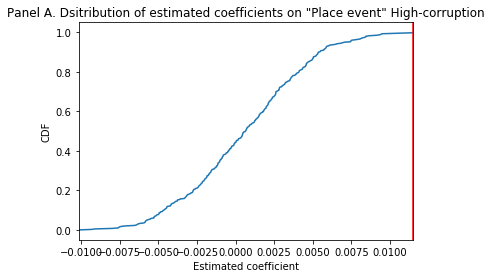

In [29]:
liste_l = []
liste_h = []
for mark in ["m","p"]:
    for _ in range(3,201):
        evsembPlac = data["evsemb"+ mark + str(_)]
        evsembPlacd2cpi = data["evsemb"+ mark + str(_)] * data["d2cpi"]
        x = data[["d2cpi","const"]]
        x = x.join([evsembPlac, evsembPlacd2cpi])
        x.columns = ["d2cpi","const","evsembPlac", "evsembPlacd2cpi"]
        y = data["aret3ri"]
        date = data.loc[x.dropna().index,"date"]
        reg = statsmodels.formula.api.OLS(y,x, missing = 'drop').fit(cov_type = 'cluster', cov_kwds = {'groups':date}, use_t = True)
        liste_l.append(reg.params["evsembPlac"])
        liste_h.append(reg.params["evsembPlacd2cpi"])

liste_l = pd.Series(liste_l)
liste_l = liste_l.sort_values()
liste_l[len(liste_l)]=liste_l.iloc[-1]
cum_dist = np.linspace(0,1,len(liste_l))
liste_cdf_l = pd.Series(cum_dist,index=liste_l)
liste_h = pd.Series(liste_h)
liste_h = liste_h.sort_values()
liste_h[len(liste_h)]=liste_h.iloc[-1]
cum_dist = np.linspace(0,1,len(liste_h))
liste_cdf_h = pd.Series(cum_dist,index=liste_h)
plt.figure()
liste_cdf_l.plot().axvline(x = -0.0042 , color ="r")
plt.title('Panel A. Dsitribution of estimated coefficients on "Place event"')
plt.ylabel("CDF")
plt.xlabel("Estimated coefficient")
plt.figure()
liste_cdf_h.plot().axvline(x = 0.0115 , color ="r")
plt.title('Panel A. Dsitribution of estimated coefficients on "Place event" High-corruption')
plt.ylabel("CDF")
plt.xlabel("Estimated coefficient")

### Model and Calibration

#### Embargo probabilities as a function of previous embargo state

In [98]:
def lag_gen(data,k):
    data_u = data.unstack("Country")
    for x in ["embargo","eve","evn"]:
        a = data_u[x].shift(periods = k)
        a = a.stack("Country").unstack("year").stack()
        data[ x + "m1" ] = a
    return data

df= pd.read_csv(path+"/data/TransProb.csv")
df = pd.wide_to_long(df,["emb","eve","evn"], i = "Country", j ="year")
df = df.rename(columns={"emb":"embargo"})
df = df.fillna(value = 0)
df = lag_gen(df,1)

cont = np.mean(df.loc[(df["embargom1"]== 1)]["embargo"])
print("Chance of staying in embargo: ",round(cont,5)*100,"%")
emb_get = np.mean(df.loc[(df["embargom1"]== 0)]["embargo"])
print("Chance of getting an embargo: ",round(emb_get,5)*100,"%")

Chance of staying in embargo:  92.771 %
Chance of getting an embargo:  4.348 %


#### Embargo probabilities as a function of events in previous year

In [111]:
desc_emb = np.mean(df.loc[df["evem1"]==-1,"embargo"])
print("Chance of getting an embargo with an important or unexpected decreasing hostility last year: ",round(desc_emb,5)*100,"%")
esc_emb = np.mean(df.loc[df["evem1"]==1,"embargo"])
print("Chance of getting an embargo with an important or unexpected escalating situation last year: ",round(esc_emb,5)*100,"%")
non_emb = np.mean(df.loc[(df["evem1"]==0) & (df["embargom1"] == 1) ]["embargo"])
print("Chance of staying in embargo without a significant or unexpected situation last year: ",round(non_emb,5)*100,"%")

Chance of getting an embargo with an important or unexpected decreasing hostility last year:  77.778 %
Chance of getting an embargo with an important or unexpected escalating situation last year:  100.0 %
Chance of staying in embargo without a significant or unexpected situation last year:  94.118 %


In [69]:
desc_emb = np.mean(df.loc[(df["evnm1"]==-1) & (df["embargom1"] == 0)]["embargo"])
print("Chance of getting an embargo with an escalating situation last year: ",round(desc_emb,5)*100,"%")
esc_emb = np.mean(df.loc[(df["evnm1"]==1) & (df["embargom1"] == 0)]["embargo"])
print("Chance of getting an embargo with decreasing hostility last year: ",round(esc_emb,5)*100,"%")
nnon_emb = np.mean(df.loc[(df["evnm1"]==0) & (df["embargom1"] == 0) ]["embargo"])
print("Chance of getting an embargo without a significant situation last year: ",round(nnon_emb,5)*100,"%")

Chance of getting an embargo with an escalating situation last year:  20.0 %
Chance of getting an embargo with decreasing hostility last year:  8.696 %
Chance of getting an embargo without a significant situation last year:  3.556 %


#### Probit specification for effect of conflict events on Embargo probabilities

In [58]:
evem1_dec = df.loc[(abs(df["evem1"])==1) | (df["embargom1"] == 1),"evem1"]
evem1_dec = np.array(evem1_dec).reshape(len(evem1_dec),1)
embargo1_dec = df.loc[(abs(df["evem1"])==1) | (df["embargom1"] == 1),"embargo"]
embargo1_dec = np.array(embargo1_dec).reshape(len(embargo1_dec),1)
prob_model1 = pysal.model.spreg.probit.Probit(embargo1_dec,evem1_dec,scalem='xmean' , name_x=["Escalating Event"] ,name_y="embargo")
#print(prob_model1.summary)
print(str(float(prob_model1.slopes)*100) + "%")

10.00071115570636%


An event in the previous year, has a 10% marginal effect on removal of an embargo.

In [114]:
evnm1_dec = df.loc[(abs(df["evnm1"])==1) | (df["embargom1"] == 0),"evnm1"]
evnm1_dec = np.array(evnm1_dec).reshape(len(evnm1_dec),1)
embargo0_dec = df.loc[(abs(df["evnm1"])==1) | (df["embargom1"] == 0),"embargo"]
embargo0_dec = np.array(embargo0_dec).reshape(len(embargo0_dec),1)
prob_model2 = pysal.model.spreg.probit.Probit(embargo0_dec,evnm1_dec,scalem='xmean',name_x=["Deescalating event"], name_y = "embargo")
#print(prob_model2.summary)
print(str(float(prob_model2.slopes)*100) + "%")

6.330147730734836%


An event in the previous year, has a 6.33% marginal effect on getting an embargo.